In [1]:
from experiment import Experiment
import torch
torch.manual_seed(2)
%matplotlib inline

In [2]:
var_dict = dict(
    categorical_vars = ['Work_accident', 'promotion_last_5years', 'sales', 
                        'salary', 'number_project','time_spend_company'],
    numerical_vars = ['satisfaction_level', 'last_evaluation', 'average_montly_hours'],
    class_var = 'left'
)

In [3]:
exp = Experiment('data/HR_comma_sep.csv', 
                 var_dict,
                 embedding_dim=64,
                 lr=0.001,
                 batch_size=1024,
                 weight_decay=0.001,
                 n_epoch=200,
                 verbose=True,
                 n_bins_range=[10,15],#range(15, 16),
                 n_init_bins_list=[15])

In [4]:
print('#Numerical Vars =', len(var_dict['numerical_vars']))
print('#Categorical Vars =', len(var_dict['categorical_vars']))
print('#Dummy coded categorical cols =', exp.n_dummy_coded_categorical_cols)

#Numerical Vars = 3
#Categorical Vars = 6
#Dummy coded categorical cols = 17


In [5]:
%time clf_scores = exp.test_classification_performance(cv=3)

>>> Epoch = 1, Loss = 0.5039176940917969
>>> Epoch = 2, Loss = 0.40646520256996155
>>> Epoch = 3, Loss = 0.3518145978450775
>>> Epoch = 4, Loss = 0.3308670222759247
>>> Epoch = 5, Loss = 0.31484711170196533
>>> Epoch = 6, Loss = 0.304911345243454
>>> Epoch = 7, Loss = 0.2991163730621338
>>> Epoch = 8, Loss = 0.2980811595916748
>>> Epoch = 9, Loss = 0.2968277335166931
>>> Epoch = 10, Loss = 0.295453280210495
>>> Epoch = 11, Loss = 0.2954832911491394
>>> Epoch = 12, Loss = 0.2951345443725586
>>> Epoch = 13, Loss = 0.2959950864315033
>>> Epoch = 14, Loss = 0.2936806380748749
>>> Epoch = 15, Loss = 0.2951517701148987
>>> Epoch = 16, Loss = 0.2949126660823822
>>> Epoch = 17, Loss = 0.2932814061641693
>>> Epoch = 18, Loss = 0.29301905632019043
>>> Epoch = 19, Loss = 0.2940373420715332
>>> Epoch = 20, Loss = 0.2960737347602844
>>> Epoch = 21, Loss = 0.29390981793403625
>>> Epoch = 22, Loss = 0.29440248012542725
>>> Epoch = 23, Loss = 0.29513445496559143
>>> Epoch = 24, Loss = 0.29477202892303

>>> Epoch = 193, Loss = 0.3005032539367676
>>> Epoch = 194, Loss = 0.3006538152694702
>>> Epoch = 195, Loss = 0.299648255109787
>>> Epoch = 196, Loss = 0.29894331097602844
>>> Epoch = 197, Loss = 0.29975220561027527
>>> Epoch = 198, Loss = 0.3007860779762268
>>> Epoch = 199, Loss = 0.2997751533985138
>>> Epoch = 200, Loss = 0.3004385232925415
Learning Embedding Finished!
>>> Epoch = 1, Loss = 0.5079420208930969
>>> Epoch = 2, Loss = 0.4048275649547577
>>> Epoch = 3, Loss = 0.35461992025375366
>>> Epoch = 4, Loss = 0.3221987783908844
>>> Epoch = 5, Loss = 0.31357669830322266
>>> Epoch = 6, Loss = 0.30618518590927124
>>> Epoch = 7, Loss = 0.29859068989753723
>>> Epoch = 8, Loss = 0.29993003606796265
>>> Epoch = 9, Loss = 0.2965909540653229
>>> Epoch = 10, Loss = 0.2977072596549988
>>> Epoch = 11, Loss = 0.2939075827598572
>>> Epoch = 12, Loss = 0.2958206534385681
>>> Epoch = 13, Loss = 0.29509437084198
>>> Epoch = 14, Loss = 0.2933639883995056
>>> Epoch = 15, Loss = 0.29588982462882996
>

>>> Epoch = 185, Loss = 0.2994944155216217
>>> Epoch = 186, Loss = 0.299130380153656
>>> Epoch = 187, Loss = 0.2998754680156708
>>> Epoch = 188, Loss = 0.30011817812919617
>>> Epoch = 189, Loss = 0.3009718954563141
>>> Epoch = 190, Loss = 0.2995321750640869
>>> Epoch = 191, Loss = 0.3007841110229492
>>> Epoch = 192, Loss = 0.3007872700691223
>>> Epoch = 193, Loss = 0.3001341223716736
>>> Epoch = 194, Loss = 0.29994043707847595
>>> Epoch = 195, Loss = 0.3007904291152954
>>> Epoch = 196, Loss = 0.30036917328834534
>>> Epoch = 197, Loss = 0.3011089563369751
>>> Epoch = 198, Loss = 0.2994128167629242
>>> Epoch = 199, Loss = 0.29891714453697205
>>> Epoch = 200, Loss = 0.29942309856414795
Learning Embedding Finished!
>>> Epoch = 1, Loss = 0.5121305584907532
>>> Epoch = 2, Loss = 0.4207446277141571
>>> Epoch = 3, Loss = 0.360053688287735
>>> Epoch = 4, Loss = 0.3427462875843048
>>> Epoch = 5, Loss = 0.31539100408554077
>>> Epoch = 6, Loss = 0.3102821111679077
>>> Epoch = 7, Loss = 0.304627299

>>> Epoch = 176, Loss = 0.298586905002594
>>> Epoch = 177, Loss = 0.30074506998062134
>>> Epoch = 178, Loss = 0.29997408390045166
>>> Epoch = 179, Loss = 0.30011311173439026
>>> Epoch = 180, Loss = 0.30036187171936035
>>> Epoch = 181, Loss = 0.2993992865085602
>>> Epoch = 182, Loss = 0.2983638346195221
>>> Epoch = 183, Loss = 0.2987533211708069
>>> Epoch = 184, Loss = 0.29866188764572144
>>> Epoch = 185, Loss = 0.3007252812385559
>>> Epoch = 186, Loss = 0.2998208701610565
>>> Epoch = 187, Loss = 0.29941585659980774
>>> Epoch = 188, Loss = 0.2996649146080017
>>> Epoch = 189, Loss = 0.2994694113731384
>>> Epoch = 190, Loss = 0.29994291067123413
>>> Epoch = 191, Loss = 0.2994418442249298
>>> Epoch = 192, Loss = 0.29841580986976624
>>> Epoch = 193, Loss = 0.299325555562973
>>> Epoch = 194, Loss = 0.2999018728733063
>>> Epoch = 195, Loss = 0.29886430501937866
>>> Epoch = 196, Loss = 0.3013264536857605
>>> Epoch = 197, Loss = 0.30071374773979187
>>> Epoch = 198, Loss = 0.2992743253707886
>>>

In [6]:
exp.print_classification_scores(clf_scores, method='dummy_only')

DT performance
#cols = 34.0, Accuracy = 0.959 (+/- 0.003)
LR performance
#cols = 34.0, Accuracy = 0.896 (+/- 0.008)


In [7]:
exp.print_classification_scores(clf_scores, method='scale_numeric')

DT performance
#cols = 34.0, Accuracy = 0.959 (+/- 0.003)
LR performance
#cols = 34.0, Accuracy = 0.896 (+/- 0.008)


In [8]:
exp.print_classification_scores(clf_scores, method='equal_width')

DT performance
#Bins = 10, #Avg Cols = 61.0, Accuracy = 0.929 (+/- 0.006)
#Bins = 15, #Avg Cols = 76.0, Accuracy = 0.941 (+/- 0.012)
LR performance
#Bins = 10, #Avg Cols = 61.0, Accuracy = 0.942 (+/- 0.001)
#Bins = 15, #Avg Cols = 76.0, Accuracy = 0.953 (+/- 0.003)
NB performance
#Bins = 10, #Avg Cols = 61.0, Accuracy = 0.920 (+/- 0.005)
#Bins = 15, #Avg Cols = 76.0, Accuracy = 0.926 (+/- 0.008)


In [9]:
exp.print_classification_scores(clf_scores, method='equal_freq')

DT performance
#Bins = 10, #Avg Cols = 61.0, Accuracy = 0.931 (+/- 0.007)
#Bins = 15, #Avg Cols = 76.0, Accuracy = 0.936 (+/- 0.007)
LR performance
#Bins = 10, #Avg Cols = 61.0, Accuracy = 0.937 (+/- 0.006)
#Bins = 15, #Avg Cols = 76.0, Accuracy = 0.948 (+/- 0.003)
NB performance
#Bins = 10, #Avg Cols = 61.0, Accuracy = 0.906 (+/- 0.008)
#Bins = 15, #Avg Cols = 76.0, Accuracy = 0.918 (+/- 0.006)


In [10]:
exp.print_classification_scores(clf_scores, method='semantic_binning')

DT performance
#Init Bins = 15, #Avg Cols = 61.333333333333336, Accuracy = 0.934 (+/- 0.006)
LR performance
#Init Bins = 15, #Avg Cols = 61.333333333333336, Accuracy = 0.931 (+/- 0.004)
NB performance
#Init Bins = 15, #Avg Cols = 61.333333333333336, Accuracy = 0.894 (+/- 0.002)


In [11]:
exp.semantic_binning.bins_by_var

{'average_montly_hours': {'bins': ['(95.999, 142.0]',
   '(142.0, 150.0]',
   '(150.0, 158.0]',
   '(158.0, 168.0]',
   '(168.0, 180.0]',
   '(180.0, 192.0]',
   '(192.0, 220.0]',
   '(220.0, 231.0]',
   '(231.0, 243.0]',
   '(243.0, 252.0]',
   '(252.0, 262.0]',
   '(262.0, 310.0]'],
  'split_point': [95.999,
   142.0,
   150.0,
   158.0,
   168.0,
   180.0,
   192.0,
   220.0,
   231.0,
   243.0,
   252.0,
   262.0,
   310.0]},
 'last_evaluation': {'bins': ['(0.359, 0.57]',
   '(0.57, 0.65]',
   '(0.65, 0.7]',
   '(0.7, 0.74]',
   '(0.74, 0.79]',
   '(0.79, 0.86]',
   '(0.86, 0.9]',
   '(0.9, 0.93]',
   '(0.93, 0.97]',
   '(0.97, 1.0]'],
  'split_point': [0.359,
   0.57,
   0.65,
   0.7,
   0.74,
   0.79,
   0.86,
   0.9,
   0.93,
   0.97,
   1.0]},
 'satisfaction_level': {'bins': ['(0.089, 0.31]',
   '(0.31, 0.4]',
   '(0.4, 0.51]',
   '(0.51, 0.57]',
   '(0.57, 0.8]',
   '(0.8, 0.85]',
   '(0.85, 1.0]'],
  'split_point': [0.089, 0.31, 0.4, 0.51, 0.57, 0.8, 0.85, 1.0]}}

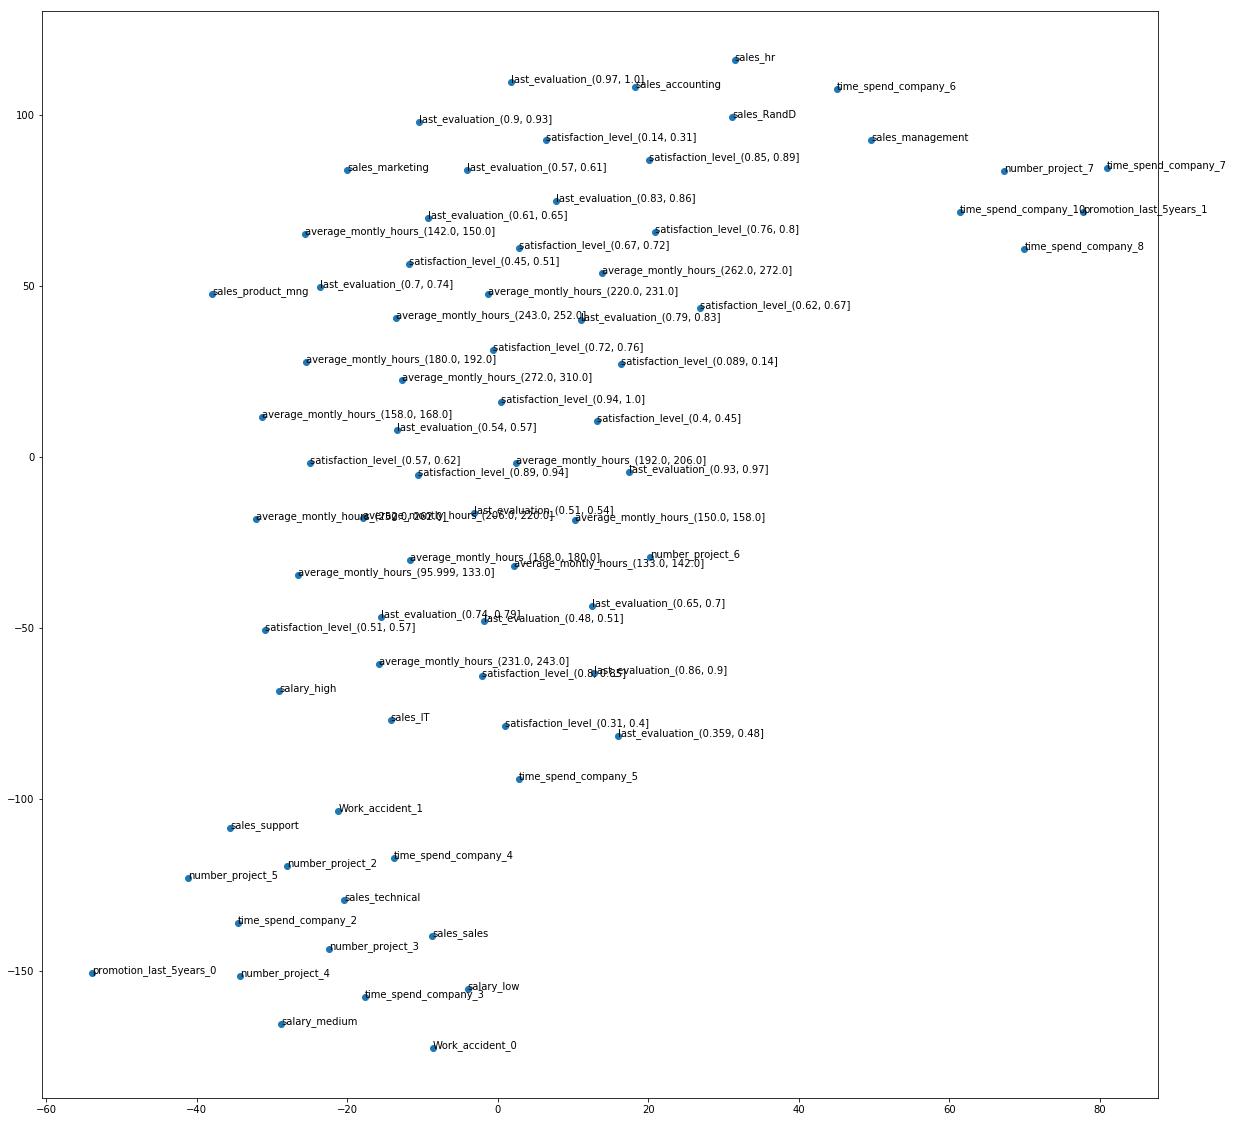

In [12]:
exp.semantic_binning.visualize_bin_embeddings()

In [ ]:
torch.optim.SGD()

### 학습된 트리의 깊이, 형태 비교

In [13]:
# dot_data = StringIO()
# export_graphviz(dt, out_file=dot_data, feature_names=X.columns, 
#                 impurity=False, proportion=True)
# graph = pydot.graph_from_dot_data(dot_data.getvalue())

In [184]:
exp = Experiment('data/HR_comma_sep.csv', 
                 var_dict,
                 embedding_dim=8,
                 lr=0.001,
                 batch_size=1024,
                 n_epoch=230,
                 verbose=True,
                 n_bins_range=[10,15],#range(15, 16),
                 n_init_bins_list=[15])

In [185]:
% time exp.semantic_binning.fit(exp.data, n_init_bins=15)

>>> Epoch = 1, Loss = 0.6118088960647583
>>> Epoch = 2, Loss = 0.48133814334869385
>>> Epoch = 3, Loss = 0.36849671602249146
>>> Epoch = 4, Loss = 0.3136087656021118
>>> Epoch = 5, Loss = 0.28964224457740784
>>> Epoch = 6, Loss = 0.27667102217674255
>>> Epoch = 7, Loss = 0.27336010336875916
>>> Epoch = 8, Loss = 0.26946529746055603
>>> Epoch = 9, Loss = 0.26604601740837097
>>> Epoch = 10, Loss = 0.26532796025276184
>>> Epoch = 11, Loss = 0.26437100768089294
>>> Epoch = 12, Loss = 0.26401767134666443
>>> Epoch = 13, Loss = 0.2644307315349579
>>> Epoch = 14, Loss = 0.26292577385902405
>>> Epoch = 15, Loss = 0.2633987367153168
>>> Epoch = 16, Loss = 0.26088017225265503
>>> Epoch = 17, Loss = 0.2621919810771942
>>> Epoch = 18, Loss = 0.2625342905521393
>>> Epoch = 19, Loss = 0.2619907855987549
>>> Epoch = 20, Loss = 0.26069164276123047
>>> Epoch = 21, Loss = 0.26002082228660583
>>> Epoch = 22, Loss = 0.2618776559829712
>>> Epoch = 23, Loss = 0.2618426978588104
>>> Epoch = 24, Loss = 0.2613

>>> Epoch = 193, Loss = 0.2512037754058838
>>> Epoch = 194, Loss = 0.2529282867908478
>>> Epoch = 195, Loss = 0.25059548020362854
>>> Epoch = 196, Loss = 0.253091961145401
>>> Epoch = 197, Loss = 0.24859634041786194
>>> Epoch = 198, Loss = 0.24962615966796875
>>> Epoch = 199, Loss = 0.2521379590034485
>>> Epoch = 200, Loss = 0.25069984793663025
>>> Epoch = 201, Loss = 0.2511564791202545
>>> Epoch = 202, Loss = 0.2512115240097046
>>> Epoch = 203, Loss = 0.25014355778694153
>>> Epoch = 204, Loss = 0.2497529238462448
>>> Epoch = 205, Loss = 0.25137919187545776
>>> Epoch = 206, Loss = 0.25191250443458557
>>> Epoch = 207, Loss = 0.2504079341888428
>>> Epoch = 208, Loss = 0.25056302547454834
>>> Epoch = 209, Loss = 0.24914498627185822
>>> Epoch = 210, Loss = 0.2517125606536865
>>> Epoch = 211, Loss = 0.25155109167099
>>> Epoch = 212, Loss = 0.2525412440299988
>>> Epoch = 213, Loss = 0.2526753544807434
>>> Epoch = 214, Loss = 0.25039777159690857
>>> Epoch = 215, Loss = 0.25127559900283813
>>>

In [208]:
temp = exp.semantic_binning.bin_embedder.embedding_by_column
import numpy as np
import seaborn as sns
from sklearn.metrics import pairwise_distances

def get_pairwise_dist_btw_embeddings_of_var(variable, embedding_by_column):
    
    def get_begin_point_of_bin(col):
        return float(col.split('_(')[-1].split(',')[0])
        
    embedding_by_col = [(col, e) for col, e in embedding_by_column.items() if variable in col]
    embedding_by_col = sorted(embedding_by_col, key=lambda x: get_begin_point_of_bin(x[0]))
    
    cols = [x[0] for x in embedding_by_col]
    dist_matrix = pairwise_distances(np.array([x[1] for x in embedding_by_col]))
    
    return cols, dist_matrix

def plot_dist_btw_cols(cols, dist_matrix):
    sns.heatmap(dist_matrix, cmap='coolwarm', yticklabels=cols)


def find_nn(query, embedding_by_column, k=30, exclude_self=False):
    embedding_of_query = embedding_by_column[query]
    distances = dict()
    for col, embedding in embedding_by_column.items():
        distances[col] = np.linalg.norm(embedding - embedding_of_query)
    knn = sorted(distances.items(), key=lambda x: x[1])
    if exclude_self:
        knn = knn[1:]
    return knn[:k]

temp_cols = sorted([x for x in find_nn('average_montly_hours_(95.999, 133.0]', temp, k=100)
        if 'average_montly' in x[0]], key=lambda x: float(x[0].split('_')[-1].split(', ')[0][1:]))

In [223]:
avg_hours_dist_mtx, avg_hours_cols = get_pairwise_dist_btw_embeddings_of_var('average_montly_hours', temp)

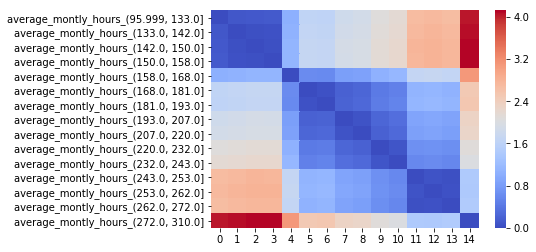

In [225]:
plot_dist_btw_cols(avg_hours_dist_mtx, avg_hours_cols)

In [215]:
satis_dist_mtx, satis_cols = get_pairwise_dist_btw_embeddings_of_var('satisfaction_level', temp)

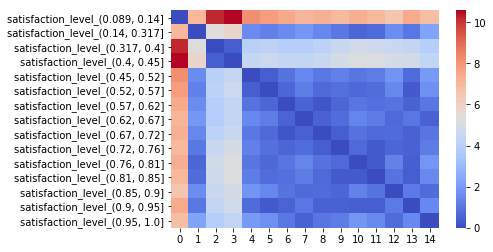

In [216]:
plot_dist_btw_cols(satis_dist_mtx, satis_cols)

In [217]:
last_dist_mtx, last_cols = get_pairwise_dist_btw_embeddings_of_var('last_evaluation', temp)

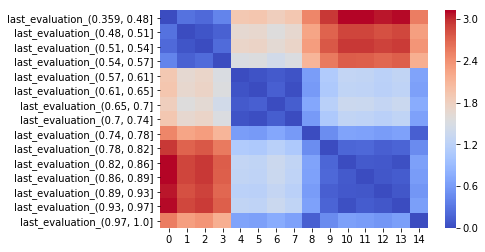

In [218]:
plot_dist_btw_cols(last_dist_mtx, last_cols)

In [187]:
temp_embeddnigs = [(x, v) for x, v in temp.items() if 'average_montly' in x]

In [189]:
exp.semantic_binning.bins_by_var['average_montly_hours']

{'bins': ['(95.999, 158.0]',
  '(158.0, 168.0]',
  '(168.0, 193.0]',
  '(193.0, 220.0]',
  '(220.0, 243.0]',
  '(243.0, 272.0]',
  '(272.0, 310.0]'],
 'split_point': [95.999, 158.0, 168.0, 193.0, 220.0, 243.0, 272.0, 310.0]}

### Epoch 30

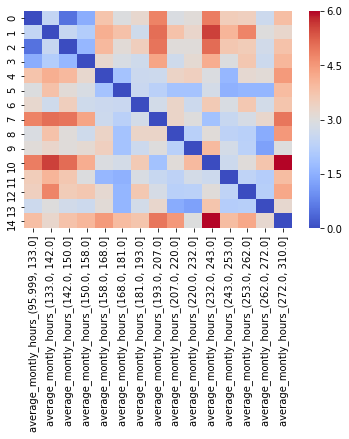

In [155]:
sns.heatmap(pairwise_distances(np.array([x[1] for x in temp_embeddnigs])),
           cmap='coolwarm', xticklabels=[x[0] for x in temp_embeddnigs])

### Epoch 50

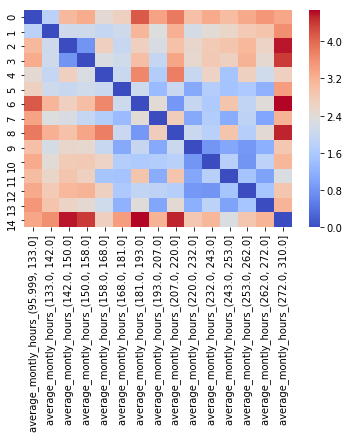

In [127]:
sns.heatmap(pairwise_distances(np.array([x[1] for x in temp_embeddnigs])),
           cmap='coolwarm', xticklabels=[x[0] for x in temp_embeddnigs])

### Epoch 70

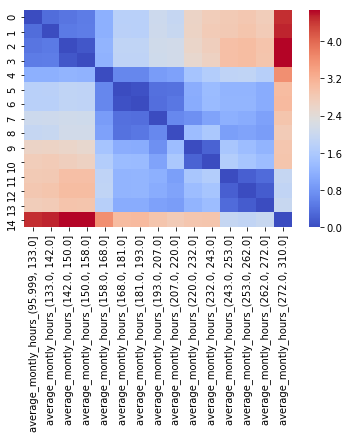

In [162]:
sns.heatmap(pairwise_distances(np.array([x[1] for x in temp_embeddnigs])),
           cmap='coolwarm', xticklabels=[x[0] for x in temp_embeddnigs])

### Epoch 100

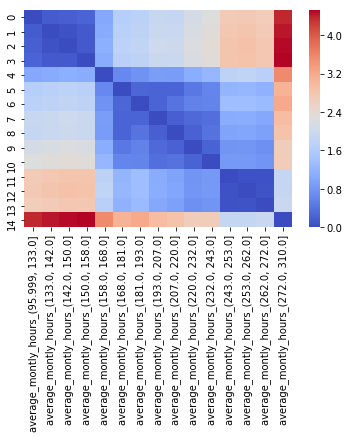

In [120]:
sns.heatmap(pairwise_distances(np.array([x[1] for x in temp_embeddnigs])),
           cmap='coolwarm', xticklabels=[x[0] for x in temp_embeddnigs])

### Epoch 130

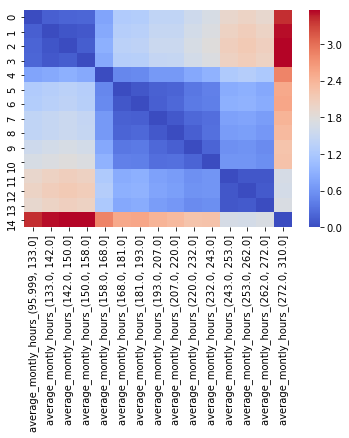

In [141]:
sns.heatmap(pairwise_distances(np.array([x[1] for x in temp_embeddnigs])),
           cmap='coolwarm', xticklabels=[x[0] for x in temp_embeddnigs])

### Epoch 150

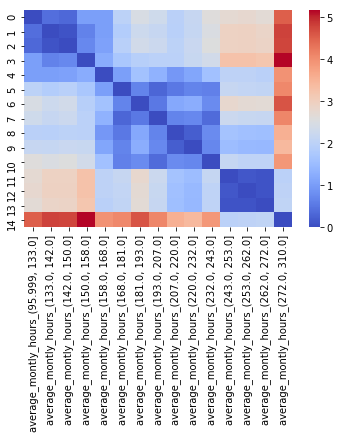

In [134]:
sns.heatmap(pairwise_distances(np.array([x[1] for x in temp_embeddnigs])),
           cmap='coolwarm', xticklabels=[x[0] for x in temp_embeddnigs])

### Epoch 170

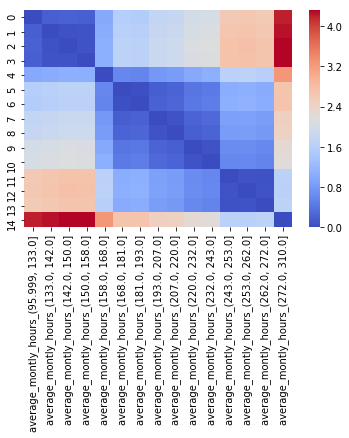

In [183]:
sns.heatmap(pairwise_distances(np.array([x[1] for x in temp_embeddnigs])),
           cmap='coolwarm', xticklabels=[x[0] for x in temp_embeddnigs])

### Epoch 200

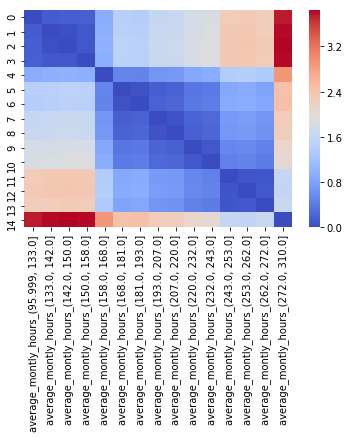

In [148]:
sns.heatmap(pairwise_distances(np.array([x[1] for x in temp_embeddnigs])),
           cmap='coolwarm', xticklabels=[x[0] for x in temp_embeddnigs])

### Epoch 230

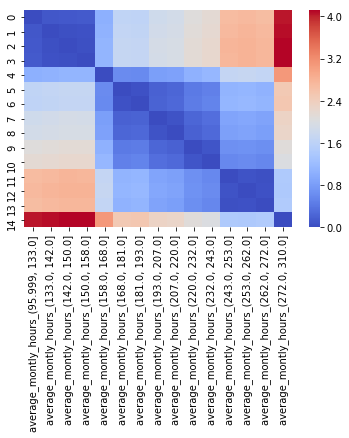

In [190]:
sns.heatmap(pairwise_distances(np.array([x[1] for x in temp_embeddnigs])),
           cmap='coolwarm', xticklabels=[x[0] for x in temp_embeddnigs])

### Epoch 250

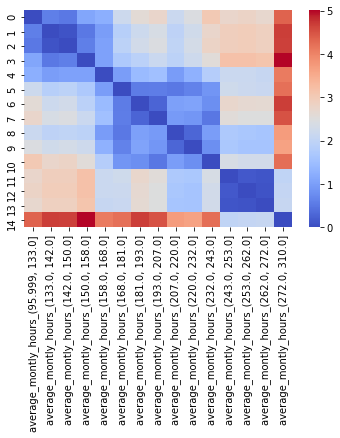

In [176]:
sns.heatmap(pairwise_distances(np.array([x[1] for x in temp_embeddnigs])),
           cmap='coolwarm', xticklabels=[x[0] for x in temp_embeddnigs])

### Epoch 300

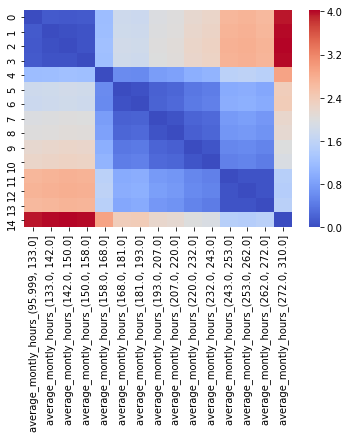

In [169]:
sns.heatmap(pairwise_distances(np.array([x[1] for x in temp_embeddnigs])),
           cmap='coolwarm', xticklabels=[x[0] for x in temp_embeddnigs])